DeepRitz ML model for solving the monodomain problem 
Using the IMEX time dependend formula 

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.autograd as autograd
import torch.nn.functional as F


In [2]:
# n_x, n_y grid size for x and y
# sigma_h, sigma_d conductivity of healthy and diseased regions
# dr, lists of the diseased regions points (x_center, y_center, radius) to fit the (x−0.3)^2 +(y−0.7)^2 <0.1^2 formulas
# returns a 2D array of all the points in the grid with the healthy and diseased regions marked
def cond_map(n_x, n_y, sigma_h, sigma_d, dr):
    x = np.linspace(0, 1, n_x)
    y = np.linspace(0, 1, n_y)
    X, Y = np.meshgrid(x, y, indexing='ij')
    sigma = np.full((n_x, n_y), sigma_h)

    for (xc, yc, r) in dr:
        mask = (X - xc)**2 + (Y - yc)**2 < r**2
        sigma[mask] = sigma_d

    return sigma


Initial condition function

Using device: cpu


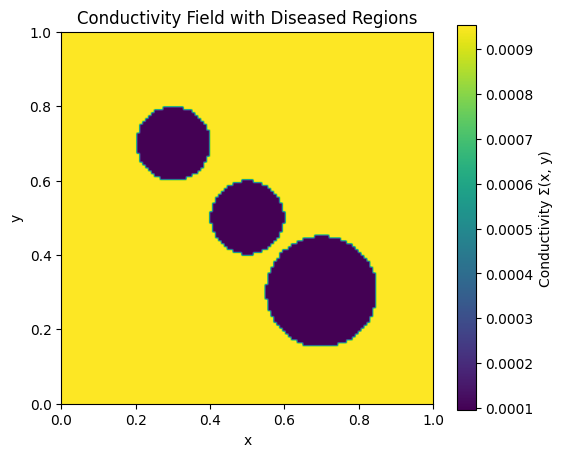

In [3]:
# params
n_x, n_y = 128, 128
dr = [(0.3, 0.7, 0.1), (0.7, 0.3, 0.15), (0.5, 0.5, 0.1)]
sigma_h = 9.5298e-4
# sigma_d = 10 * sigma_h
# sigma_d = sigma_h
sigma_d = 0.1 * sigma_h
a = 18.515
ft = 0.2383
fr = 0
fd = 1
T = 35
sigma = cond_map(n_x, n_y, sigma_h, sigma_d, dr)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
sigma_t = torch.tensor(sigma.flatten(), dtype=torch.float32).to(device)


# heart map values
plt.figure(figsize=(6, 5))
plt.imshow(sigma.T, origin='lower', extent=[0,1,0,1], cmap='viridis')
plt.colorbar(label='Conductivity Σ(x, y)')
plt.title('Conductivity Field with Diseased Regions')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(False)
plt.show()



In [4]:
# u0(x, y) = 1 if x ≥ 0.9 and y ≥ 0.9, else 0.
# returns u0 as a 2D array
def ic(n_x, n_y):
    x = np.linspace(0, 1, n_x)
    y = np.linspace(0, 1, n_y)
    X, Y = np.meshgrid(x, y, indexing='ij')

    u0 = np.zeros((n_x, n_y))
    u0[(X >= 0.9) & (Y >= 0.9)] = 1.0
    return u0

Reaction term

In [5]:
# reaction term 
def R(u, a, fr, ft, fd):
    return a * (u - fr) * (u - ft) * (u - fd)

RHS of the IMEX eq

In [6]:
# RHS = (1/dt) * u^n - f(u^n)
# u_n, solution at time step n
# dt : time step size
# returns a 2D array pf the rhs
def rhs(u_n, a, fr, ft, fd, dt):
    f_un = R(u_n, a, fr, ft, fd)
    return (1.0 / dt) * u_n + f_un

Model 

In [7]:
class DeepRitz(nn.Module):
    def __init__(self, input_dim=2, output_dim=1, w=64, d=4):
        super().__init__()
        self.linear = nn.ModuleList([nn.Linear(w if i>0 else input_dim, w) for i in range(d)])
        self.linearOut = nn.Linear(w, output_dim)

        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)  
                nn.init.zeros_(m.bias)

    # def forward(self, x):
    #     x = F.softplus(self.linear[0](x))  
    #     for layer in self.linear[1:]:
    #         x_temp = F.softplus(layer(x))
    #         x = x + x_temp
    #     return self.linearOut(x)
    
    def forward(self, x):
        x = F.softplus(self.linear[0](x))
        for layer in self.linear[1:]:
            x_temp = F.softplus(layer(x))
            x = x + x_temp
        return torch.sigmoid(self.linearOut(x))


Sample points

In [8]:
# sample collocation points, random uniform 
# biased to add more to the ic 
def sample_cps(N, domain=(0, 1), ic=(0.9, 0.9), br=0.2):
    n_ic = int(N * br)
    n_uniform = N - n_ic

    x_ic = np.random.uniform(ic[0], 1.0, size=(n_ic,))
    y_ic = np.random.uniform(ic[1], 1.0, size=(n_ic,))
    x = np.random.uniform(domain[0], domain[1], size=(n_uniform,))
    y = np.random.uniform(domain[0], domain[1], size=(n_uniform,))

    x_all = np.concatenate([x, x_ic])
    y_all = np.concatenate([y, y_ic])
    return torch.tensor(np.stack([x_all, y_all], axis=-1), dtype=torch.float32)

Energy function

In [9]:
# interpolation functions to allow samplinh at the collocation points
def rhs_norm(points):
    idx_x = (points[:, 0] * (n_x - 1)).long()
    idx_y = (points[:, 1] * (n_y - 1)).long()
    return rhs_t[idx_x * n_y + idx_y].unsqueeze(1)

def sigma_norm(points):
    idx_x = (points[:, 0] * (n_x - 1)).long()
    idx_y = (points[:, 1] * (n_y - 1)).long()
    return sigma_t[idx_x * n_y + idx_y].unsqueeze(1)

def energy_f(model, points, sigma_norm, rhs_norm, dt, x):
    x.requires_grad_(True)
    u = model(x).squeeze()
    grad_u = autograd.grad(outputs=u, inputs=x, grad_outputs=torch.ones_like(u), create_graph=True)[0] # ∇u^{n+1}
    sigma_vals = sigma_norm(points).squeeze()        # sigma(x, y)
    rhs_vals = rhs_norm(points).squeeze()            # (1/dt) u^n - f(u^n)

    grad_norm_sq = (grad_u**2).sum(dim=1)            # ||grad(u)||²

    # M u^(n+1) + dt K u^{n+1} = M u^n - dt f(u^n)
    # where K = 1/2 *sigma * grad^2
    energy = 0.5 * sigma_vals * grad_norm_sq + (0.5 / dt) * u**2 - rhs_vals * u
    return energy.mean() 

Training 

In [10]:
# training func
def train(model, points, sigma_norm, rhs_norm, dt, lr, steps, device, ic_target=None, full_grid=None):
    model.train()
    points = points.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    losses = []

    for epoch in range(steps):
        optimizer.zero_grad()
        loss = energy_f(model, points, sigma_norm, rhs_norm, dt, points)
        if ic_target is not None and full_grid is not None:   # to weight gradient loss for reinforcement of it
            model.eval()
            u_pred = model(full_grid).squeeze()
            ic_loss = F.mse_loss(u_pred, ic_target)
            loss += 10 * ic_loss  
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % (steps // 10 if steps >= 10 else 1) == 0:
            print(f"    Epoch [{epoch+1}/{steps}], Loss: {loss.item():.8f}")
    
    return model, losses

In [11]:
def stats(model, xy, u_n, sigma_norm, dt, a, fr, ft, fd):
    xy = xy.clone().detach().requires_grad_(True)
    u_pred = model(xy).squeeze()
    grad_u = autograd.grad(u_pred, xy, grad_outputs=torch.ones_like(u_pred),create_graph=True, retain_graph=True)[0]
    sigma_vals = sigma_norm(xy).squeeze()
    flux = sigma_vals.unsqueeze(-1) * grad_u
    div_diff = 0
    for i in range(xy.shape[1]):
        div_flux_i = autograd.grad(
            outputs=flux[:, i],
            inputs=xy,
            grad_outputs=torch.ones_like(flux[:, i]),
            create_graph=True,
            retain_graph=True
        )[0][:, i]
        div_diff += div_flux_i

    idx_x = (xy[:, 0] * (n_x - 1)).long()
    idx_y = (xy[:, 1] * (n_y - 1)).long()
    u_n_vals = u_n[idx_x * n_y + idx_y].to(xy.device)
    f_un = R(u_n_vals, a, fr, ft, fd)
    dt_u_term = (u_pred - u_n_vals) / dt
    residual = dt_u_term - div_diff + f_un

    return {
        'du_dt': dt_u_term.detach().cpu().numpy(),
        'diffusion': (-div_diff).detach().cpu().numpy(),
        'reaction': f_un.detach().cpu().numpy(),
        'residual': residual.detach().cpu().numpy(),
        'grad_u': grad_u.detach().cpu().numpy()
    }

In [12]:
# compute the graddient 
def grad(model, x):
    x.requires_grad_(True) 
    u = model(x) 
    if u.ndim == 2 and u.shape[1] == 1:
        u = u.squeeze(-1)
    grad_u = torch.autograd.grad(outputs=u,inputs=x,grad_outputs=torch.ones_like(u),create_graph=True,retain_graph=True,only_inputs=True)[0]
    return grad_u

In [13]:
# //// param def ////////////////////
dt = 0.5
N = int(T/dt)
steps = 1000
colloc_p = 1024
w = 64 
d = 4
lr = 1e-5  # could get smaller 

model = DeepRitz(input_dim=2, output_dim=1, w=w, d=d).to(device)

x = np.linspace(0, 1, n_x)
y = np.linspace(0, 1, n_y)
X, Y = np.meshgrid(x, y, indexing='ij')
xy_coords = np.stack([X.flatten(), Y.flatten()], axis=-1)
xy_t = torch.tensor(xy_coords, dtype=torch.float32).to(device)

u_n = ic(n_x, n_y)
u_n = torch.tensor(u_n.flatten(), dtype=torch.float32)
u_np = u_n.detach().numpy().reshape(n_x, n_y)

rhs_v = rhs(u_np, a, fr, ft, fd, dt).flatten()
rhs_t = torch.tensor(rhs_v, dtype=torch.float32).to(device)

iter: 0 ###############################
    Epoch [100/1000], Loss: 7.98174524
    Epoch [200/1000], Loss: 2.81723356
    Epoch [300/1000], Loss: 0.31764355
    Epoch [400/1000], Loss: 0.10694355
    Epoch [500/1000], Loss: 0.10302428
    Epoch [600/1000], Loss: 0.10254602
    Epoch [700/1000], Loss: 0.10238513
    Epoch [800/1000], Loss: 0.10231463
    Epoch [900/1000], Loss: 0.10227919
    Epoch [1000/1000], Loss: 0.10225946
    Energy after iteration 0: -0.000081


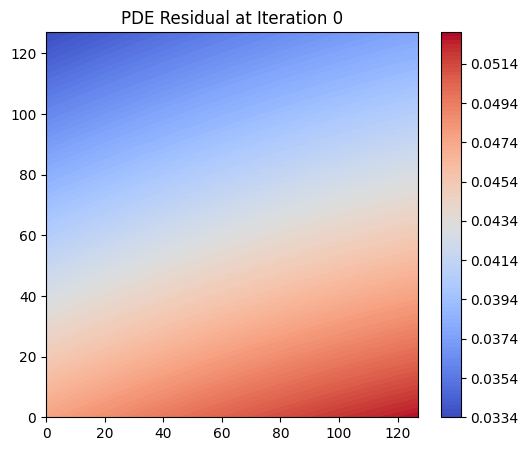

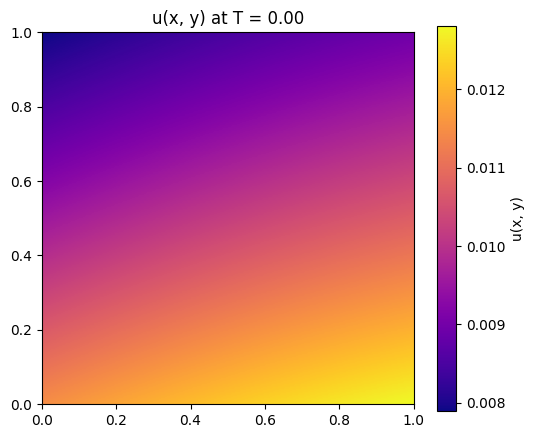

iter: 1 ###############################
    Epoch [100/1000], Loss: -0.00092400
    Epoch [200/1000], Loss: -0.00092410
    Epoch [300/1000], Loss: -0.00092410
    Epoch [400/1000], Loss: -0.00092410
    Epoch [500/1000], Loss: -0.00092410
    Epoch [600/1000], Loss: -0.00092410
    Epoch [700/1000], Loss: -0.00092410
    Epoch [800/1000], Loss: -0.00092410
    Epoch [900/1000], Loss: -0.00092410
    Epoch [1000/1000], Loss: -0.00092411
    Energy after iteration 1: -0.000924
iter: 2 ###############################
    Epoch [100/1000], Loss: -0.00760700
    Epoch [200/1000], Loss: -0.00760784
    Epoch [300/1000], Loss: -0.00760786
    Epoch [400/1000], Loss: -0.00760789
    Epoch [500/1000], Loss: -0.00760792
    Epoch [600/1000], Loss: -0.00760796
    Epoch [700/1000], Loss: -0.00760799
    Epoch [800/1000], Loss: -0.00760802
    Epoch [900/1000], Loss: -0.00760805
    Epoch [1000/1000], Loss: -0.00760808
    Energy after iteration 2: -0.007608
iter: 3 ##############################

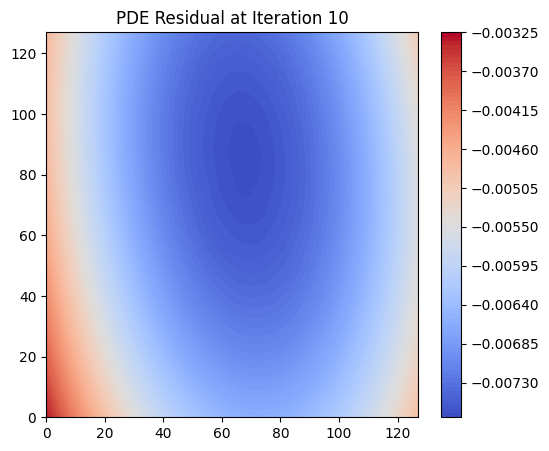

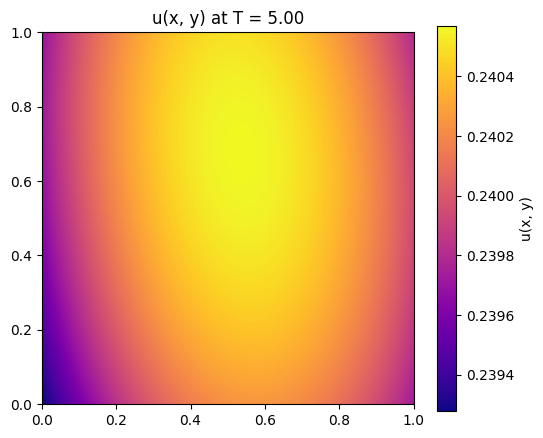

iter: 11 ###############################
    Epoch [100/1000], Loss: -0.05619477
    Epoch [200/1000], Loss: -0.05619478
    Epoch [300/1000], Loss: -0.05619478
    Epoch [400/1000], Loss: -0.05619478
    Epoch [500/1000], Loss: -0.05619478
    Epoch [600/1000], Loss: -0.05619478
    Epoch [700/1000], Loss: -0.05619478
    Epoch [800/1000], Loss: -0.05619478
    Epoch [900/1000], Loss: -0.05619478
    Epoch [1000/1000], Loss: -0.05619478
    Energy after iteration 11: -0.056195
iter: 12 ###############################
    Epoch [100/1000], Loss: -0.05718838
    Epoch [200/1000], Loss: -0.05718838
    Epoch [300/1000], Loss: -0.05718839
    Epoch [400/1000], Loss: -0.05718839
    Epoch [500/1000], Loss: -0.05718839
    Epoch [600/1000], Loss: -0.05718839
    Epoch [700/1000], Loss: -0.05718839
    Epoch [800/1000], Loss: -0.05718839
    Epoch [900/1000], Loss: -0.05718839
    Epoch [1000/1000], Loss: -0.05718839
    Energy after iteration 12: -0.057188
iter: 13 #########################

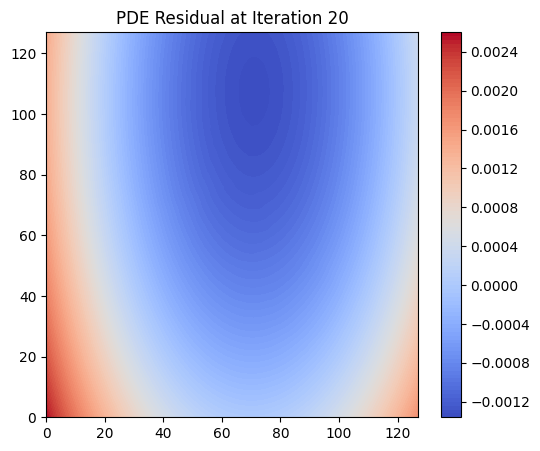

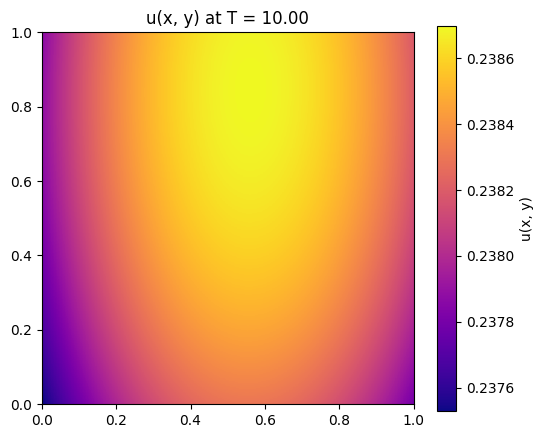

iter: 21 ###############################
    Epoch [100/1000], Loss: -0.05678498
    Epoch [200/1000], Loss: -0.05678498
    Epoch [300/1000], Loss: -0.05678498
    Epoch [400/1000], Loss: -0.05678498
    Epoch [500/1000], Loss: -0.05678498
    Epoch [600/1000], Loss: -0.05678498
    Epoch [700/1000], Loss: -0.05678498
    Epoch [800/1000], Loss: -0.05678498
    Epoch [900/1000], Loss: -0.05678498
    Epoch [1000/1000], Loss: -0.05678498
    Energy after iteration 21: -0.056785
iter: 22 ###############################
    Epoch [100/1000], Loss: -0.05678569
    Epoch [200/1000], Loss: -0.05678569
    Epoch [300/1000], Loss: -0.05678569
    Epoch [400/1000], Loss: -0.05678569
    Epoch [500/1000], Loss: -0.05678569
    Epoch [600/1000], Loss: -0.05678569
    Epoch [700/1000], Loss: -0.05678569
    Epoch [800/1000], Loss: -0.05678569
    Epoch [900/1000], Loss: -0.05678569
    Epoch [1000/1000], Loss: -0.05678569
    Energy after iteration 22: -0.056786
iter: 23 #########################

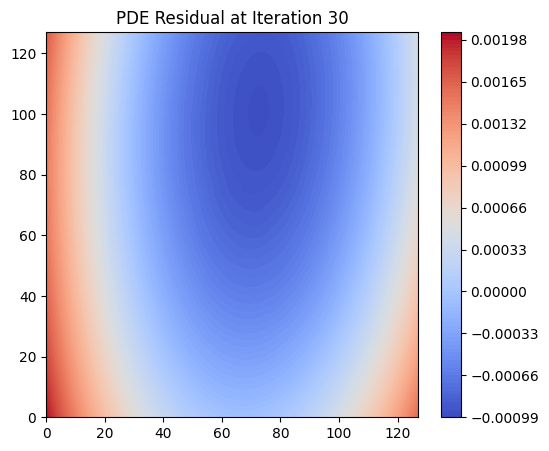

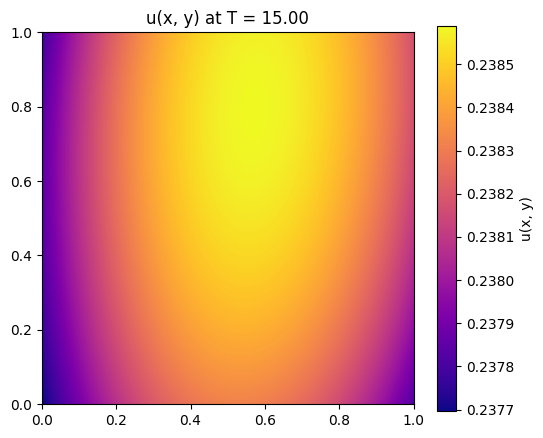

iter: 31 ###############################
    Epoch [100/1000], Loss: -0.05679344
    Epoch [200/1000], Loss: -0.05679344
    Epoch [300/1000], Loss: -0.05679344
    Epoch [400/1000], Loss: -0.05679345
    Epoch [500/1000], Loss: -0.05679344
    Epoch [600/1000], Loss: -0.05679344
    Epoch [700/1000], Loss: -0.05679344
    Epoch [800/1000], Loss: -0.05679344
    Epoch [900/1000], Loss: -0.05679344
    Epoch [1000/1000], Loss: -0.05679345
    Energy after iteration 31: -0.056793
iter: 32 ###############################
    Epoch [100/1000], Loss: -0.05678093
    Epoch [200/1000], Loss: -0.05678093
    Epoch [300/1000], Loss: -0.05678093
    Epoch [400/1000], Loss: -0.05678093
    Epoch [500/1000], Loss: -0.05678093
    Epoch [600/1000], Loss: -0.05678093
    Epoch [700/1000], Loss: -0.05678093
    Epoch [800/1000], Loss: -0.05678093
    Epoch [900/1000], Loss: -0.05678093
    Epoch [1000/1000], Loss: -0.05678093
    Energy after iteration 32: -0.056781
iter: 33 #########################

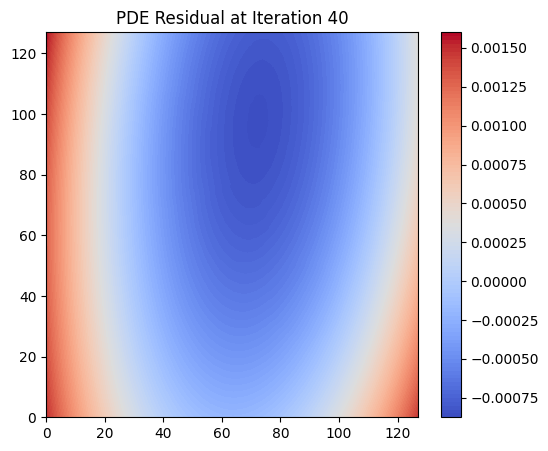

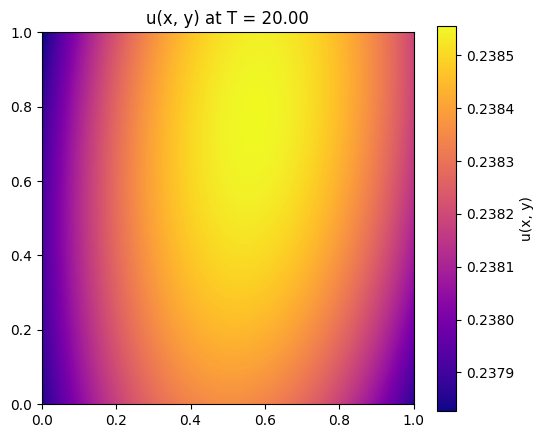

iter: 41 ###############################
    Epoch [100/1000], Loss: -0.05678768
    Epoch [200/1000], Loss: -0.05678769
    Epoch [300/1000], Loss: -0.05678769
    Epoch [400/1000], Loss: -0.05678769
    Epoch [500/1000], Loss: -0.05678768
    Epoch [600/1000], Loss: -0.05678769
    Epoch [700/1000], Loss: -0.05678769
    Epoch [800/1000], Loss: -0.05678769
    Epoch [900/1000], Loss: -0.05678769
    Epoch [1000/1000], Loss: -0.05678769
    Energy after iteration 41: -0.056788
iter: 42 ###############################
    Epoch [100/1000], Loss: -0.05678765
    Epoch [200/1000], Loss: -0.05678765
    Epoch [300/1000], Loss: -0.05678766
    Epoch [400/1000], Loss: -0.05678766
    Epoch [500/1000], Loss: -0.05678766
    Epoch [600/1000], Loss: -0.05678766
    Epoch [700/1000], Loss: -0.05678766
    Epoch [800/1000], Loss: -0.05678766
    Epoch [900/1000], Loss: -0.05678765
    Epoch [1000/1000], Loss: -0.05678766
    Energy after iteration 42: -0.056788
iter: 43 #########################

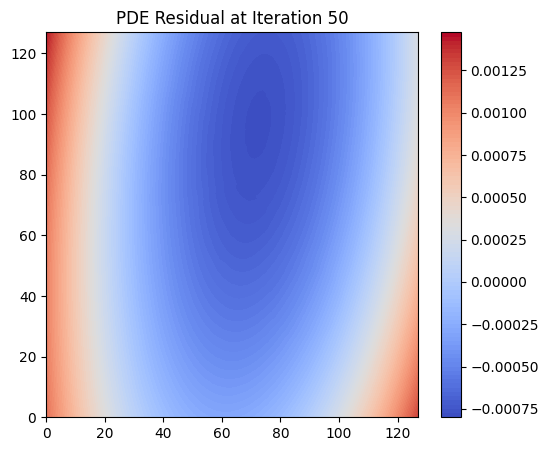

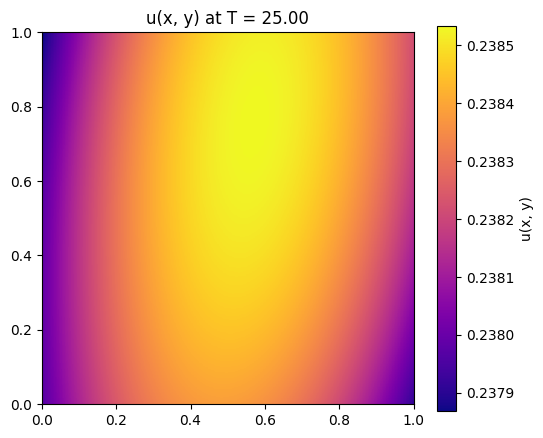

iter: 51 ###############################
    Epoch [100/1000], Loss: -0.05678649
    Epoch [200/1000], Loss: -0.05678649
    Epoch [300/1000], Loss: -0.05678649
    Epoch [400/1000], Loss: -0.05678649
    Epoch [500/1000], Loss: -0.05678649
    Epoch [600/1000], Loss: -0.05678649
    Epoch [700/1000], Loss: -0.05678649
    Epoch [800/1000], Loss: -0.05678649
    Epoch [900/1000], Loss: -0.05678649
    Epoch [1000/1000], Loss: -0.05678649
    Energy after iteration 51: -0.056786
iter: 52 ###############################
    Epoch [100/1000], Loss: -0.05678384
    Epoch [200/1000], Loss: -0.05678384
    Epoch [300/1000], Loss: -0.05678384
    Epoch [400/1000], Loss: -0.05678384
    Epoch [500/1000], Loss: -0.05678385
    Epoch [600/1000], Loss: -0.05678385
    Epoch [700/1000], Loss: -0.05678385
    Epoch [800/1000], Loss: -0.05678385
    Epoch [900/1000], Loss: -0.05678385
    Epoch [1000/1000], Loss: -0.05678385
    Energy after iteration 52: -0.056784
iter: 53 #########################

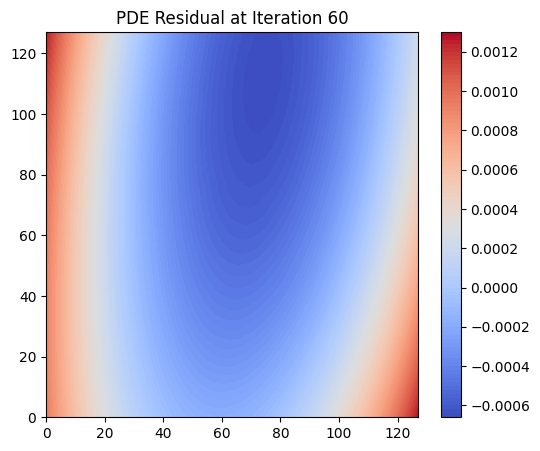

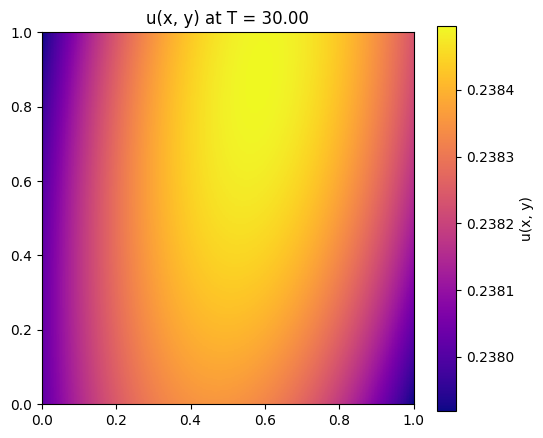

iter: 61 ###############################
    Epoch [100/1000], Loss: -0.05678637
    Epoch [200/1000], Loss: -0.05678637
    Epoch [300/1000], Loss: -0.05678637
    Epoch [400/1000], Loss: -0.05678637
    Epoch [500/1000], Loss: -0.05678637
    Epoch [600/1000], Loss: -0.05678637
    Epoch [700/1000], Loss: -0.05678637
    Epoch [800/1000], Loss: -0.05678637
    Epoch [900/1000], Loss: -0.05678637
    Epoch [1000/1000], Loss: -0.05678637
    Energy after iteration 61: -0.056786
iter: 62 ###############################
    Epoch [100/1000], Loss: -0.05678891
    Epoch [200/1000], Loss: -0.05678891
    Epoch [300/1000], Loss: -0.05678891
    Epoch [400/1000], Loss: -0.05678891
    Epoch [500/1000], Loss: -0.05678891
    Epoch [600/1000], Loss: -0.05678891
    Epoch [700/1000], Loss: -0.05678891
    Epoch [800/1000], Loss: -0.05678891
    Epoch [900/1000], Loss: -0.05678891
    Epoch [1000/1000], Loss: -0.05678891
    Energy after iteration 62: -0.056789
iter: 63 #########################

In [14]:
tot_losses = [] 
u0_tensor = u_n.to(device)     

for n in range(int(N)):
    print(f"iter: {n} ###############################")

    if n == 0:
        points = xy_t.clone().detach()
        model, losses = train(model, points, sigma_norm, rhs_norm, dt, lr, steps, device,
                              ic_target=u0_tensor, full_grid=xy_t)
    else:
        points = sample_cps(colloc_p, ic=(0.95, 0.95), br=0.4)
        model, losses = train(model, points, sigma_norm, rhs_norm, dt, lr, steps, device)

    tot_losses.extend(losses)

    u = model(points)
    grad_u = grad(model, points)
    grad_norm_sq = torch.sum(grad_u**2, dim=-1)
    diff = 0.5 * sigma_norm(points) * grad_norm_sq
    react = (0.5 / dt) * u**2
    src = rhs_norm(points) * u
    energy = (diff + react - src).mean()
    print(f"    Energy after iteration {n}: {energy.item():.6f}")

    with torch.no_grad():
        u_pred = model(xy_t).squeeze()
    u_n = u_pred.clone()
    u_np = u_n.detach().cpu().numpy().reshape(n_x, n_y)
    rhs_v = rhs(u_np, a, fr, ft, fd, dt).flatten()
    rhs_t = torch.tensor(rhs_v, dtype=torch.float32).to(device)

    graphs = stats(model, xy_t, u_n, sigma_norm, dt, a, fr, ft, fd)
    if n % 10 == 0:
        plt.figure(figsize=(6, 5))
        plt.contourf(graphs['residual'].reshape(n_x, n_y), levels=100, cmap='coolwarm')
        plt.colorbar()
        plt.title(f"PDE Residual at Iteration {n}")
        plt.show()

        plt.figure(figsize=(6, 5))
        plt.imshow(u_np, origin='lower', extent=[0,1,0,1], cmap='plasma')
        plt.colorbar(label='u(x, y)')
        plt.title(f"u(x, y) at T = {n*dt:.2f}")
        plt.show()

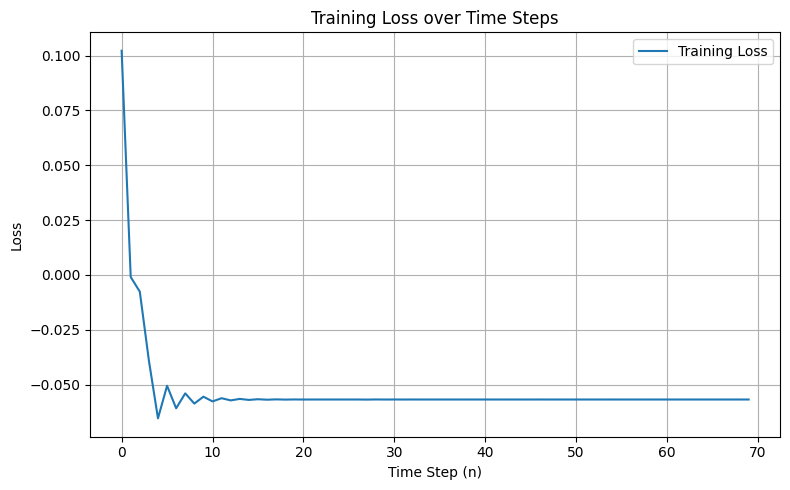

In [17]:
steps = 1000  
N = len(tot_losses) // steps 

losses_per_n = [tot_losses[i * steps + (steps - 1)] for i in range(N)]
plt.figure(figsize=(8, 5))
plt.plot(losses_per_n, label='Training Loss')
plt.xlabel("Time Step (n)")
plt.ylabel("Loss")
plt.title("Training Loss over Time Steps")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

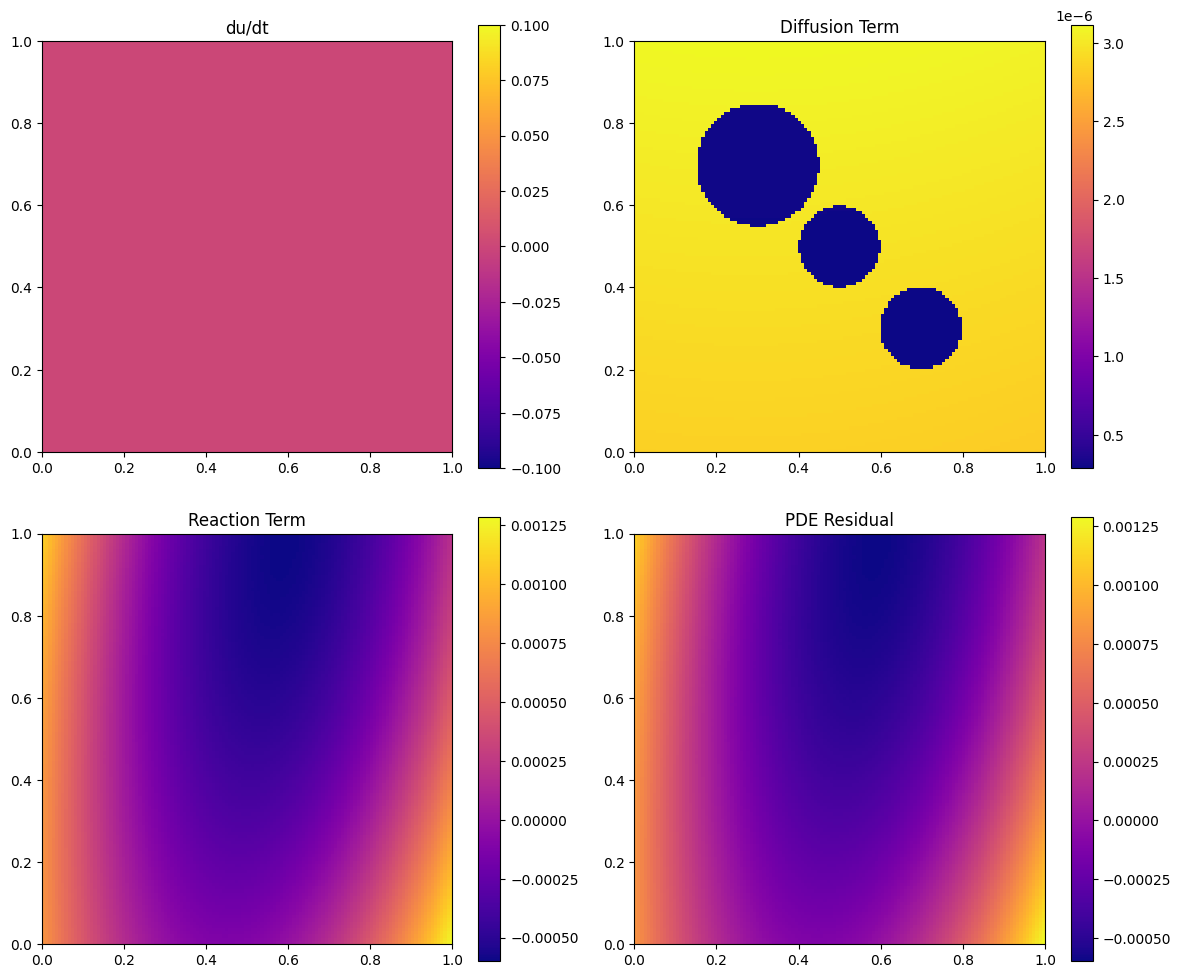

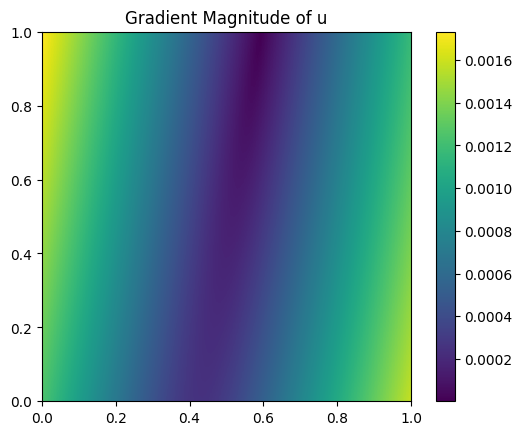

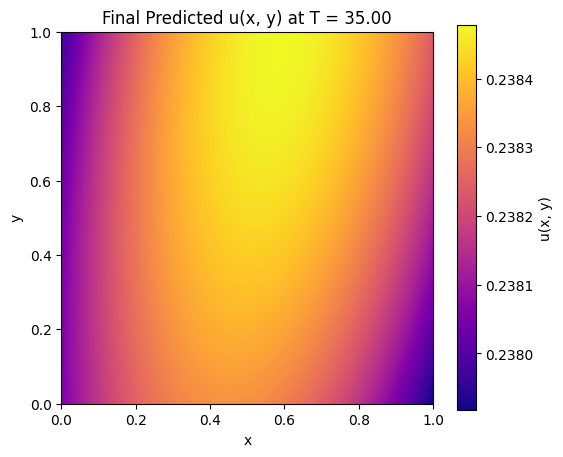

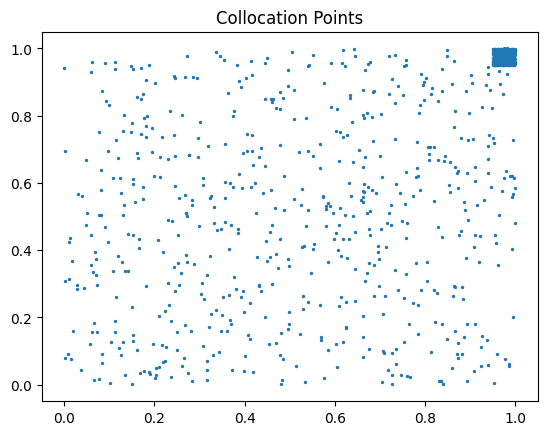

In [22]:
du_dt_map = graphs['du_dt'].reshape(n_x, n_y)
diff_map = graphs['diffusion'].reshape(n_x, n_y)
react_map = graphs['reaction'].reshape(n_x, n_y)
resid_map = graphs['residual'].reshape(n_x, n_y)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
titles = ['du/dt', 'Diffusion Term', 'Reaction Term', 'PDE Residual']
maps = [du_dt_map, diff_map, react_map, resid_map]

for ax, m, title in zip(axes.flat, maps, titles):
    im = ax.imshow(m, extent=[0, 1, 0, 1], origin='lower', cmap='plasma')
    ax.set_title(title)
    fig.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()


grad_mag = np.linalg.norm(graphs['grad_u'], axis=1).reshape(n_x, n_y)
plt.imshow(grad_mag, extent=[0,1,0,1], origin='lower')
plt.colorbar()
plt.title("Gradient Magnitude of u")
plt.show()

u_final = u_n.detach().cpu().numpy().reshape(n_x, n_y)

plt.figure(figsize=(6, 5))
plt.imshow(u_final, origin='lower', extent=[0,1,0,1], cmap='plasma')
plt.colorbar(label='u(x, y)')
plt.title('Final Predicted u(x, y) at T = {:.2f}'.format(N * dt))
plt.xlabel('x')
plt.ylabel('y')
plt.grid(False)
plt.show()

pts_np = points.detach().cpu().numpy()
plt.scatter(pts_np[:,0], pts_np[:,1], s=2)
plt.title("Collocation Points")
plt.show()